In [1]:
import pandas as pd
import numpy as np

In [10]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from yauber_backtester import Asset, Backtester, Strategy, Account, Report

# Create 1000 random assets

In [4]:
def make_rnd_asset(name):
    dt_index = pd.date_range('2010-01-01', '2018-01-01')
    ser = pd.Series(np.random.normal(size=len(dt_index)), index=dt_index).cumsum()
    asset_dict = {
            'ticker': f'RND_{name}',
            'quotes': pd.DataFrame({
                'o': ser,
                'h': ser,
                'l': ser,
                'c': ser,
                'exec': ser.shift(-1),
            }, index=ser.index),
    }
    
    return Asset(**asset_dict)
    

# Simple strategy

Each day the strategy will randompy pick on of 1000 assets in the universe, which has price greater MA200

In [6]:
class SimpleStrategy(Strategy):
    name = "SimpleStrategy"
    
    def calculate(self, asset: Asset) -> pd.DataFrame:
        """
        Calculates main logic of the strategy, this method must return pd.DataFrame or None (if asset is filtered at all)
        This information is used by portfolio composition stage
        """
        
        # Check if asset is greater MA200
        ohlc = asset.quotes()
        
        ma200 =  ohlc['c'].rolling(200).mean()
        is_gt_ma200 = ohlc['c'] > ma200
        
        return pd.DataFrame({
            'is_gt_ma200': is_gt_ma200,
            'ma200': ma200,           
        })

    def compose_portfolio(self, date: datetime, account: Account, asset_metrics: pd.DataFrame) -> dict:
        """
        Returns a dictionary of portfolio composition at specific 'date'
        :param date: analysis date
        :param account: actual account at the previous date (see. Account class interface)
        :param asset_metrics: composite pd.DataFrame returned by self.calculate() method at 'date'

        :return: dictionary of  {asset_class_instance: float_opened_quantity, ... }
        Notes:
        This method is about managing portfolios, you can implement asset ranking based on asset_metrics, or Money Management strategy.
        This method permits opening fractional position sizes, or opening positions with negative capital. You should explicitly manage
        all possible issues with portfolio composition and perform all checks in this method.

        You can use information returned by asset.info(date) to get all information about the asset. The backtester engine will use this
        information to retrieve execution price and costs, as well.
        """
        position = {}        
        
        # asset_metrics['is_gt_ma200']  is part of pd.DataFrame produced at calculate() method
        filtered_assets = asset_metrics['is_gt_ma200'] == 1
        
        # Randomly pick one of assets that has Close > MA(Close, 200)
        rnd_asset_idx = np.random.randint(0, len(filtered_assets.index))
        
        # Open long position on that asset
        position[filtered_assets.index[rnd_asset_idx]] = 1.0
          
        return position
        

# Initialize and run backtester

In [8]:
strategy = SimpleStrategy()
assets1000 = [make_rnd_asset(i) for i in range(1000)]

# Initialize backtester class
yabt = Backtester(assets1000, 
                  strategy,
                  acc_name='Random1000',
                  acc_initial_capital=1000,                  
                 )

### Backtesting speed
1000 assets x 2900 data points

In [19]:
%timeit yabt.run()

4.5 s ± 43.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Run backtester and store results

In [21]:
acc = yabt.run()

### Aquire account historical series

In [22]:
acc_df = acc.as_dataframe()
acc_df.tail()

,capital_invested,costs,equity,margin,pnl
2017-12-28,1000.0,0.0,1086.255496,-14.025577,2.040944
2017-12-29,1000.0,0.0,1085.395264,-43.333489,-0.860232
2017-12-30,1000.0,0.0,1086.575227,102.914854,1.179964
2017-12-31,1000.0,0.0,1088.034866,41.393285,1.459639
2018-01-01,1000.0,0.0,NaN,NaN,NaN


### Last opened position

In [23]:
acc.position()

{Asset<RND_566>: RND_566 x 1.0}

# Backtesting report

In [24]:
rpt = Report([acc])

In [25]:
rpt.stats()

,Random1000
MaxDD,-30.984228
NetProfit,1088.034866
NumberOfTrades,2922.000000
WinRate,0.518138


In [28]:
df_trades = rpt.trades('Random1000')
df_trades.tail()

,asset,date_entry,date_exit,side,n_transactions,wavg_price_entered,wavg_price_exited,qty_entered,qty_exited,pnl,costs
2917,RND_389,2017-12-28,2017-12-29,1,2,-14.025577,-14.885809,1.0,1.0,-0.860232,0.0
2918,RND_806,2017-12-29,2017-12-30,1,2,-43.333489,-42.153525,1.0,1.0,1.179964,0.0
2919,RND_176,2017-12-30,2017-12-31,1,2,102.914854,104.374492,1.0,1.0,1.459639,0.0
2920,RND_642,2017-12-31,2018-01-01,1,2,41.393285,NaN,1.0,1.0,-1.214518,0.0
2921,RND_566,2018-01-01,2018-01-01,1,1,NaN,NaN,1.0,0.0,0.000000,0.0


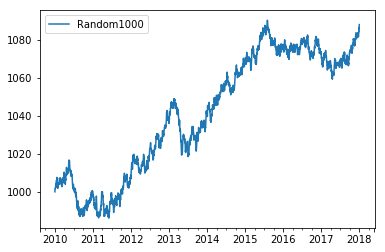

In [31]:
df_equity = rpt.series('equity')
df_equity.plot()